Predict next 144 blocks

Epoch [1/50], Loss: 11.6001
Epoch [2/50], Loss: 7.0828
Epoch [3/50], Loss: 7.0493
Epoch [4/50], Loss: 7.0331
Epoch [5/50], Loss: 6.9964
Epoch [6/50], Loss: 6.9635
Epoch [7/50], Loss: 6.8897
Epoch [8/50], Loss: 6.7905
Epoch [9/50], Loss: 6.4670
Epoch [10/50], Loss: 6.0564
Epoch [11/50], Loss: 5.8497
Epoch [12/50], Loss: 5.8197
Epoch [13/50], Loss: 5.7856
Epoch [14/50], Loss: 5.7577
Epoch [15/50], Loss: 5.8152
Epoch [16/50], Loss: 5.7796
Epoch [17/50], Loss: 5.7388
Epoch [18/50], Loss: 5.7302
Epoch [19/50], Loss: 5.7118
Epoch [20/50], Loss: 5.7126
Epoch [21/50], Loss: 5.7314
Epoch [22/50], Loss: 5.7196
Epoch [23/50], Loss: 5.7279
Epoch [24/50], Loss: 5.7004
Epoch [25/50], Loss: 5.7198
Epoch [26/50], Loss: 5.7023
Epoch [27/50], Loss: 5.6907
Epoch [28/50], Loss: 5.6966
Epoch [29/50], Loss: 5.7031
Epoch [30/50], Loss: 5.6898
Epoch [31/50], Loss: 5.7094
Epoch [32/50], Loss: 5.7009
Epoch [33/50], Loss: 5.6884
Epoch [34/50], Loss: 5.6884
Epoch [35/50], Loss: 5.6756
Epoch [36/50], Loss: 5.6867


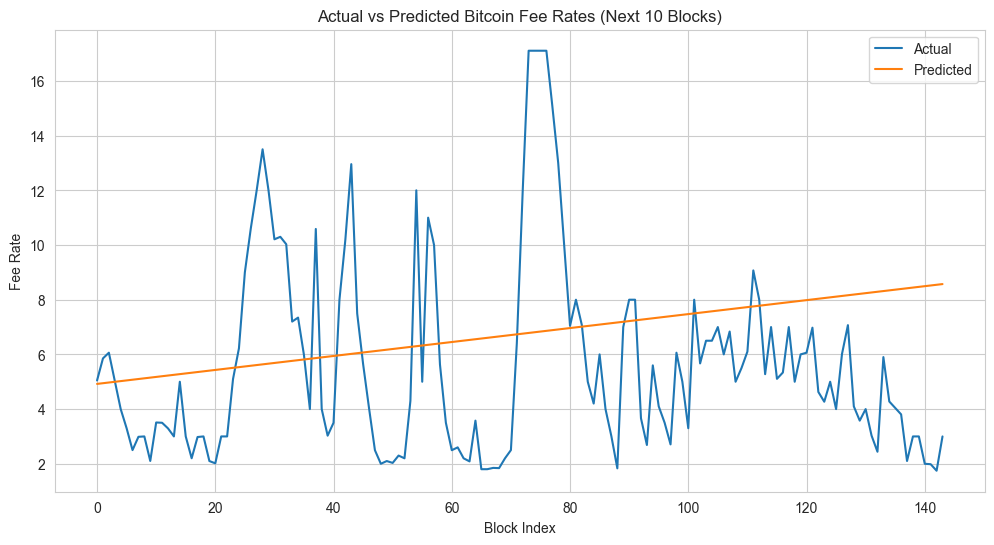


Prophet Model Performance for Next 144 Blocks:
Mean Absolute Error: 3.2107
Mean Squared Error: 15.0536
Root Mean Squared Error: 3.8799
R-squared Score: -0.22213285056876342
MAPE: 83.9234%
Directional Accuracy: 42.6573%
Theil's U Statistic: 0.6469
Training time: 432.2612590789795s


In [32]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import time
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Call the function to set the seed
set_seed(42)
start=time.time()

# Load and preprocess data_history
df = pd.read_csv('real_time_cleaned.csv')
df=df.iloc[0:3000,:]
df['block_time'] = pd.to_datetime(df['block_time'])
df = df.sort_values('block_time')

df=df[:-144]

# Separate features into categories
historical_features = [
    'tx_count', 'mempool_size_mb', 'max_fee_rate', 'avg_fee_rate',
    'median_fee_rate', 'fee_rate_10th', 'fee_rate_90th', 'fee_rate_std',
    'mempool_min_fee', 'total_fee', 'mempool_usage', 'transaction_count',
    'block_weight', 'block_interval', 'hist_low_fee_ratio',
    'hist_med_fee_ratio', 'hist_high_fee_ratio', 'hist_fee_diversity',
    'hash_rate', 'bitcoin_price_usd'
]

known_future_features = ['block_height', 'difficulty', 'block_version']

all_features = historical_features + known_future_features

# Scaling features
scaler = MinMaxScaler()
df[all_features] = scaler.fit_transform(df[all_features])

target = 'block_median_fee_rate'
max_encoder_length = 288 # Past 288 observations (48 hours)
max_prediction_length = 144  # Predict next 144 blocks (approximately 24 hours)

# Time2Vec layer
class Time2Vec(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Time2Vec, self).__init__()
        self.w0 = nn.parameter.Parameter(torch.randn(input_dim, 1))
        self.b0 = nn.parameter.Parameter(torch.randn(1))
        self.w = nn.parameter.Parameter(torch.randn(input_dim, output_dim-1))
        self.b = nn.parameter.Parameter(torch.randn(output_dim-1))
        self.f = torch.sin

    def forward(self, x):
        v1 = torch.matmul(x, self.w0) + self.b0
        v2 = self.f(torch.matmul(x, self.w) + self.b)
        return torch.cat([v1, v2], -1)

# Define custom dataset
class Time2VecDataset(Dataset):
    def __init__(self, data, historical_features, future_known_features, target, max_encoder_length, max_prediction_length):
        self.data = data
        self.historical_features = historical_features
        self.future_known_features = future_known_features
        self.target = target
        self.max_encoder_length = max_encoder_length
        self.max_prediction_length = max_prediction_length

    def __len__(self):
        return len(self.data) - self.max_encoder_length - self.max_prediction_length + 1

    def __getitem__(self, idx):
        encoder_start = idx
        encoder_end = idx + self.max_encoder_length
        decoder_end = encoder_end + self.max_prediction_length

        historical_data = self.data.iloc[encoder_start:encoder_end][self.historical_features]
        future_known_data = self.data.iloc[encoder_end:decoder_end][self.future_known_features]
        target_values = self.data.iloc[encoder_end:decoder_end][self.target]

        # Create time feature (assuming each step is 10 minutes apart)
        time_feature = torch.arange(0, self.max_encoder_length, dtype=torch.float32).unsqueeze(1)

        x_hist = torch.tensor(historical_data.values, dtype=torch.float)
        x_future = torch.tensor(future_known_data.values, dtype=torch.float)
        y = torch.tensor(target_values.values, dtype=torch.float)

        return time_feature, x_hist, x_future, y

# Create dataset and dataloaders
dataset = Time2VecDataset(df, historical_features, known_future_features, target, max_encoder_length, max_prediction_length)
batch_size = 32#32
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# BitcoinFeeModel class remains the same as 10 blocks
class BitcoinFeeModel(nn.Module):
    def __init__(self, hist_input_dim, future_input_dim, time2vec_dim, hidden_dim, output_dim, num_predictions):
        super(BitcoinFeeModel, self).__init__()
        self.time2vec = Time2Vec(1, time2vec_dim)
        self.lstm = nn.LSTM(hist_input_dim + time2vec_dim, hidden_dim, batch_first=True)
        self.fc_combine = nn.Linear(hidden_dim + future_input_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, output_dim)
        self.num_predictions = num_predictions

    def forward(self, time_feature, x_hist, x_future):
        batch_size, seq_len, _ = x_hist.shape
        time_encoded = self.time2vec(time_feature).expand(batch_size, seq_len, -1)
        x_hist_time = torch.cat([x_hist, time_encoded], dim=-1)
        
        _, (h_n, _) = self.lstm(x_hist_time)
        h_n = h_n.squeeze(0)
        
        outputs = []
        for i in range(self.num_predictions):
            combined = torch.cat((h_n, x_future[:, i, :]), dim=1)
            hidden = self.fc_combine(combined)
            out = self.fc_out(hidden)
            outputs.append(out)
        
        return torch.cat(outputs, dim=1)
# Model parameters
hist_input_dim = len(historical_features)
future_known_dim = len(known_future_features)
time2vec_dim = 20 #20
hidden_dim = 128 # 128
output_dim = 1
num_predictions = max_prediction_length

# Instantiate model, loss function, and optimizer
model = BitcoinFeeModel(hist_input_dim, future_known_dim, time2vec_dim, hidden_dim, output_dim, num_predictions)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)  # 0.0002

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 50  # Increased number of epochs

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for time_feature, x_hist, x_future_known, y in train_dataloader:
        time_feature, x_hist, x_future_known, y = time_feature.to(device), x_hist.to(device), x_future_known.to(device), y.to(device)

        # Forward pass
        outputs = model(time_feature, x_hist, x_future_known)
        loss = criterion(outputs, y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Make future predictions
def predict_future(model, data, historical_features, known_future_features, max_encoder_length, max_prediction_length):
    model.eval()
    hist_data = data.tail(max_encoder_length)[historical_features].values
    last_block_height = data['block_height'].iloc[-1]
    last_difficulty = data['difficulty'].iloc[-1]
    last_block_version = data['block_version'].iloc[-1]
    
    future_known_data = np.zeros((max_prediction_length, len(known_future_features)))
    for i in range(max_prediction_length):
        future_known_data[i] = [last_block_height + i + 1, last_difficulty, last_block_version]
    
    time_feature = torch.arange(0, max_encoder_length, dtype=torch.float32).unsqueeze(1).to(device)
    x_hist = torch.tensor(hist_data, dtype=torch.float).unsqueeze(0).to(device)
    x_future_known = torch.tensor(future_known_data, dtype=torch.float).unsqueeze(0).to(device)

    with torch.no_grad():
        predictions = model(time_feature, x_hist, x_future_known).cpu().numpy().flatten()

    return predictions

# Predict next 144 blocks
future_predictions = predict_future(model, df, historical_features, known_future_features, max_encoder_length, max_prediction_length)
end=time.time()

df = pd.read_csv('real_time_cleaned.csv')
# Plot results
plt.figure(figsize=(12, 6))
y_true = df[target].iloc[-max_prediction_length:].values
plt.plot(range(len(y_true)), y_true, label='Actual')
plt.plot(range(len(future_predictions)), future_predictions, label='Predicted')
plt.title('Actual vs Predicted Bitcoin Fee Rates (Next 10 Blocks)')
plt.xlabel('Block Index')
plt.ylabel('Fee Rate')
plt.legend()
plt.show()

# Calculate performance metrics
mae = mean_absolute_error(y_true, future_predictions)
mse = mean_squared_error(y_true, future_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, future_predictions)

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def directional_accuracy(y_true, y_pred):
    return np.mean((np.diff(y_true) * np.diff(y_pred)) > 0) * 100

def theil_u(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate the percent changes
    y_true_pct = (y_true[1:] - y_true[:-1]) / y_true[:-1]
    y_pred_pct = (y_pred[1:] - y_true[:-1]) / y_true[:-1]  # Use y_true[:-1] as the base for both
    
    # Calculate Theil's U statistic
    numerator = np.sqrt(np.mean((y_true_pct - y_pred_pct)**2))
    denominator = np.sqrt(np.mean(y_true_pct**2)) + np.sqrt(np.mean(y_pred_pct**2))
    
    return numerator / denominator


mape = mean_absolute_percentage_error(y_true, future_predictions)
da = directional_accuracy(y_true, future_predictions)
theils_u = theil_u(y_true, future_predictions)
end=time.time()

print("\nProphet Model Performance for Next 144 Blocks:")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared Score: {r2}")
print(f"MAPE: {mape:.4f}%")
print(f"Directional Accuracy: {da:.4f}%")
print(f"Theil's U Statistic: {theils_u:.4f}")
print(f"Training time: {end-start}s")

In [2]:
future_predictions

array([  4.3113365,   5.089325 ,   5.8673134,   6.645301 ,   7.4232893,
         8.201278 ,   8.979266 ,   9.757255 ,  10.535242 ,  11.3132305,
        12.09122  ,  12.869206 ,  13.647196 ,  14.425183 ,  15.203171 ,
        15.981161 ,  16.759148 ,  17.537136 ,  18.315125 ,  19.093113 ,
        19.8711   ,  20.64909  ,  21.427078 ,  22.205067 ,  22.983051 ,
        23.761042 ,  24.539032 ,  25.317019 ,  26.095005 ,  26.872993 ,
        27.650986 ,  28.428972 ,  29.206959 ,  29.98495  ,  30.76294  ,
        31.540924 ,  32.318913 ,  33.096897 ,  33.87489  ,  34.652878 ,
        35.430866 ,  36.20885  ,  36.98684  ,  37.764828 ,  38.54282  ,
        39.320805 ,  40.098797 ,  40.87678  ,  41.65477  ,  42.43276  ,
        43.21075  ,  43.988735 ,  44.766724 ,  45.544712 ,  46.322704 ,
        47.100685 ,  47.878677 ,  48.656666 ,  49.434654 ,  50.212643 ,
        50.990627 ,  51.768612 ,  52.546604 ,  53.324596 ,  54.10258  ,
        54.880573 ,  55.658558 ,  56.436543 ,  57.214535 ,  57.9

# cross validation

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler,RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Dict, Tuple
import time
import random

@dataclass
class ModelConfig:
    """Configuration for LSTM model"""
    time2vec_dim: int = 20   #[16, 20, 24, 32]
    hidden_dim: int = 128  #128   [32, 64, 96, 128]
    batch_size: int = 128  #128
    learning_rate: float =0.00005 #0.0002  next try 0.005
    num_epochs: int = 100
    max_encoder_length: int = 288# 288  # Past 288 observations (48 hours)
    max_prediction_length: int = 144  # Predict next 144 blocks (24 hours)
    # Added gradient clipping
    clip_grad_norm: float =1.0   #[0.1, 0.5, 1.0, 2.0, 5.0]
    # Added warm-up epochs
    warmup_epochs: int = 3   # [1, 3, 5, 7, 10]
    
    # Early stopping parameters
    patience: int = 10
    min_delta: float = 1e-4
    
class EarlyStopping:
    """Early stopping handler"""
    def __init__(self, patience: int = 7, min_delta: float = 1e-4, verbose: bool = True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.val_loss_min = float('inf')

    def __call__(self, val_loss: float, model: nn.Module) -> bool:
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
        return self.early_stop

@dataclass
class ModelMetrics:
    """Store model evaluation metrics"""
    mae: float
    rmse: float
    r2: float
    mape: float
    theil_u: float
    directional_accuracy: float

class Time2Vec(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super(Time2Vec, self).__init__()
        self.w0 = nn.parameter.Parameter(torch.randn(input_dim, 1))
        self.b0 = nn.parameter.Parameter(torch.randn(1))
        self.w = nn.parameter.Parameter(torch.randn(input_dim, output_dim-1))
        self.b = nn.parameter.Parameter(torch.randn(output_dim-1))
        self.f = torch.sin

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        v1 = torch.matmul(x, self.w0) + self.b0
        v2 = self.f(torch.matmul(x, self.w) + self.b)
        return torch.cat([v1, v2], -1)

class BitcoinFeeModel(nn.Module):
    def __init__(self, hist_input_dim: int, future_input_dim: int, config: ModelConfig):
        super(BitcoinFeeModel, self).__init__()
        self.time2vec = Time2Vec(1, config.time2vec_dim)
        self.lstm = nn.LSTM(hist_input_dim + config.time2vec_dim, config.hidden_dim, batch_first=True)
        self.fc_combine = nn.Linear(config.hidden_dim + future_input_dim, config.hidden_dim)
        self.fc_out = nn.Linear(config.hidden_dim, 1)
        self.num_predictions = config.max_prediction_length

    def forward(self, time_feature: torch.Tensor, x_hist: torch.Tensor, 
                x_future: torch.Tensor) -> torch.Tensor:
        batch_size, seq_len, _ = x_hist.shape
        time_encoded = self.time2vec(time_feature).expand(batch_size, seq_len, -1)
        x_hist_time = torch.cat([x_hist, time_encoded], dim=-1)
        
        _, (h_n, _) = self.lstm(x_hist_time)
        h_n = h_n.squeeze(0)
        
        outputs = []
        for i in range(self.num_predictions):
            combined = torch.cat((h_n, x_future[:, i, :]), dim=1)
            hidden = self.fc_combine(combined)
            out = self.fc_out(hidden)
            outputs.append(out)
        
        return torch.cat(outputs, dim=1)

class Time2VecDataset(Dataset):
    def __init__(self, data: pd.DataFrame, historical_features: List[str], 
                 future_known_features: List[str], target: str, config: ModelConfig):
        self.data = data
        self.historical_features = historical_features
        self.future_known_features = future_known_features
        self.target = target
        self.config = config

    def __len__(self) -> int:
        return len(self.data) - self.config.max_encoder_length - self.config.max_prediction_length + 1

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        encoder_start = idx
        encoder_end = idx + self.config.max_encoder_length
        decoder_end = encoder_end + self.config.max_prediction_length

        historical_data = self.data.iloc[encoder_start:encoder_end][self.historical_features]
        future_known_data = self.data.iloc[encoder_end:decoder_end][self.future_known_features]
        target_values = self.data.iloc[encoder_end:decoder_end][self.target]

        time_feature = torch.arange(0, self.config.max_encoder_length, dtype=torch.float32).unsqueeze(1)
        x_hist = torch.tensor(historical_data.values, dtype=torch.float)
        x_future = torch.tensor(future_known_data.values, dtype=torch.float)
        y = torch.tensor(target_values.values, dtype=torch.float)

        return time_feature, x_hist, x_future, y

import torch.optim.lr_scheduler as lr_scheduler

class BitcoinFeePredictor:
    def __init__(self, config: ModelConfig = ModelConfig()):
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        self.historical_features = [
            'tx_count', 'mempool_size_mb', 'max_fee_rate', 'avg_fee_rate',
            'median_fee_rate', 'fee_rate_10th', 'fee_rate_90th', 'fee_rate_std',
            'mempool_min_fee', 'total_fee', 'mempool_usage', 'transaction_count',
            'block_weight', 'block_interval', 'hist_low_fee_ratio',
            'hist_med_fee_ratio', 'hist_high_fee_ratio', 'hist_fee_diversity',
            'hash_rate', 'bitcoin_price_usd'
        ]
        
        self.known_future_features = ['block_height', 'difficulty', 'block_version']
        self.target = 'block_median_fee_rate'
        
    # def prepare_data(self, df: pd.DataFrame) -> pd.DataFrame:
    #     """Prepare and scale data"""
    #     all_features = self.historical_features + self.known_future_features
    #     scaler = MinMaxScaler()
    #     df[all_features] = scaler.fit_transform(df[all_features])
    #     return df
    
        
    # def train_model(self, train_data: pd.DataFrame) -> BitcoinFeeModel:
    #     """Train a single model with a learning rate scheduler"""
    #     dataset = Time2VecDataset(train_data, self.historical_features, 
    #                               self.known_future_features, self.target, self.config)
    #     dataloader = DataLoader(dataset, batch_size=self.config.batch_size, 
    #                             shuffle=True, drop_last=True)
    #     
    #     model = BitcoinFeeModel(len(self.historical_features), 
    #                             len(self.known_future_features), self.config).to(self.device)
    #     criterion = nn.MSELoss()
    #     optimizer = optim.Adam(model.parameters(), lr=self.config.learning_rate)
    #     
    #     # Implementing the ReduceLROnPlateau scheduler
    #     scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
    #                                                factor=0.1, patience=5, 
    #                                                verbose=True, min_lr=1e-6)
    #     
    #     for epoch in range(self.config.num_epochs):
    #         model.train()
    #         running_loss = 0.0
    #         for time_feature, x_hist, x_future_known, y in dataloader:
    #             time_feature = time_feature.to(self.device)
    #             x_hist = x_hist.to(self.device)
    #             x_future_known = x_future_known.to(self.device)
    #             y = y.to(self.device)
    # 
    #             outputs = model(time_feature, x_hist, x_future_known)
    #             loss = criterion(outputs, y)
    # 
    #             optimizer.zero_grad()
    #             loss.backward()
    #             optimizer.step()
    # 
    #             running_loss += loss.item()
    #         
    #         # Step the scheduler after each epoch based on the average running loss
    #         scheduler.step(running_loss / len(dataloader))
    #         
    #         # Optionally, print the current learning rate
    #         current_lr = optimizer.param_groups[0]['lr']
    #         print(f"Epoch {epoch+1}/{self.config.num_epochs}, Loss: {running_loss:.4f}, Learning Rate: {current_lr:.6f}")
    #         
    #     return model

    def prepare_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """Prepare and scale data with robust scaling"""
        all_features = self.historical_features + self.known_future_features
        
        # Log transform the target variable if it's highly skewed
        # df['block_median_fee_rate'] = np.log1p(df['block_median_fee_rate'])
        
        # Use RobustScaler instead of MinMaxScaler
        scaler = RobustScaler()
        df[all_features] = scaler.fit_transform(df[all_features])
        return df
        
    def create_validation_dataloader(self, train_data: pd.DataFrame) -> DataLoader:
        """Create validation dataloader from last 20% of training data"""
        val_size = int(len(train_data) * 0.2)
        val_data = train_data.iloc[-val_size:]
        val_dataset = Time2VecDataset(val_data, self.historical_features, 
                                    self.known_future_features, self.target, self.config)
        return DataLoader(val_dataset, batch_size=self.config.batch_size, 
                         shuffle=False, drop_last=True)

    def validate_model(self, model: nn.Module, val_loader: DataLoader, 
                      criterion: nn.Module) -> float:
        """Run validation and return validation loss"""
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for time_feature, x_hist, x_future_known, y in val_loader:
                time_feature = time_feature.to(self.device)
                x_hist = x_hist.to(self.device)
                x_future_known = x_future_known.to(self.device)
                y = y.to(self.device)

                outputs = model(time_feature, x_hist, x_future_known)
                loss = criterion(outputs, y)
                val_loss += loss.item()
        
        return val_loss / len(val_loader)

    def train_model(self, train_data: pd.DataFrame) -> BitcoinFeeModel:
        """Train model with early stopping and validation"""
        # Split data into train and validation
        train_size = int(len(train_data) * 0.8)
        train_subset = train_data.iloc[:train_size]
        
        # Create dataloaders
        train_dataset = Time2VecDataset(train_subset, self.historical_features, 
                                      self.known_future_features, self.target, self.config)
        train_loader = DataLoader(train_dataset, batch_size=self.config.batch_size, 
                                shuffle=True, drop_last=True)
        val_loader = self.create_validation_dataloader(train_data)
        
        model = BitcoinFeeModel(len(self.historical_features), 
                               len(self.known_future_features), self.config).to(self.device)
        criterion = nn.HuberLoss()
        optimizer = optim.AdamW(model.parameters(), lr=self.config.learning_rate,
                              weight_decay=0.01,betas=(0.9,0.999))
        
        # Initialize schedulers
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0=10, T_mult=2, eta_min=1e-6
        )
        
        warmup_scheduler = lr_scheduler.LinearLR(
            optimizer, 
            start_factor=0.1,
            end_factor=1.0,
            total_iters=self.config.warmup_epochs
        ) if self.config.warmup_epochs > 0 else None
        
        # Initialize early stopping
        early_stopping = EarlyStopping(
            patience=self.config.patience,
            min_delta=self.config.min_delta
        )
        
        # Save best model
        best_model_state = None
        best_val_loss = float('inf')
        
        for epoch in range(self.config.num_epochs):
            model.train()
            running_loss = 0.0
            
            # Training loop
            for time_feature, x_hist, x_future_known, y in train_loader:
                time_feature = time_feature.to(self.device)
                x_hist = x_hist.to(self.device)
                x_future_known = x_future_known.to(self.device)
                y = y.to(self.device)

                outputs = model(time_feature, x_hist, x_future_known)
                loss = criterion(outputs, y)

                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), self.config.clip_grad_norm)
                optimizer.step()
                running_loss += loss.item()
            
            # Calculate average training loss
            train_loss = running_loss / len(train_loader)
            
            # Validation phase
            val_loss = self.validate_model(model, val_loader, criterion)
            
            # Update learning rate
            if epoch < self.config.warmup_epochs and warmup_scheduler:
                warmup_scheduler.step()
            else:
                scheduler.step()
            
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch+1}/{self.config.num_epochs}, "
                  f"Train Loss: {train_loss:.4f}, "
                  f"Val Loss: {val_loss:.4f}, "
                  f"Learning Rate: {current_lr:.6f}")
            
            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = model.state_dict().copy()
            
            # Early stopping check
            if early_stopping(val_loss, model):
                print("Early stopping triggered")
                break
        
        # Load best model
        if best_model_state is not None:
            model.load_state_dict(best_model_state)
        
        return model          

    
    def predict(self, model: BitcoinFeeModel, data: pd.DataFrame) -> np.ndarray:
        """Make predictions using the trained model"""
        model.eval()
        hist_data = data.tail(self.config.max_encoder_length)[self.historical_features].values
        
        future_known_data = np.zeros((self.config.max_prediction_length, len(self.known_future_features)))
        last_block_height = data['block_height'].iloc[-1]
        last_difficulty = data['difficulty'].iloc[-1]
        last_block_version = data['block_version'].iloc[-1]
        
        for i in range(self.config.max_prediction_length):
            future_known_data[i] = [last_block_height + i + 1, last_difficulty, last_block_version]
        
        time_feature = torch.arange(0, self.config.max_encoder_length, dtype=torch.float32).unsqueeze(1).to(self.device)
        x_hist = torch.tensor(hist_data, dtype=torch.float).unsqueeze(0).to(self.device)
        x_future_known = torch.tensor(future_known_data, dtype=torch.float).unsqueeze(0).to(self.device)

        with torch.no_grad():
            predictions = model(time_feature, x_hist, x_future_known).cpu().numpy().flatten()
            
        # Transform predictions back to original scale
        # predictions = np.expm1(predictions)          
        return predictions
    
    @staticmethod
    def calculate_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> ModelMetrics:
        """Calculate evaluation metrics"""
        def mean_absolute_percentage_error(y_true, y_pred):
            return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

        def directional_accuracy(y_true, y_pred):
            return np.mean((np.diff(y_true) * np.diff(y_pred)) > 0) * 100

        def theil_u(y_true, y_pred):
            y_true_pct = (y_true[1:] - y_true[:-1]) / y_true[:-1]
            y_pred_pct = (y_pred[1:] - y_true[:-1]) / y_true[:-1]
            numerator = np.sqrt(np.mean((y_true_pct - y_pred_pct)**2))
            denominator = np.sqrt(np.mean(y_true_pct**2)) + np.sqrt(np.mean(y_pred_pct**2))
            return numerator / denominator

        return ModelMetrics(
            mae=mean_absolute_error(y_true, y_pred),
            rmse=np.sqrt(mean_squared_error(y_true, y_pred)),
            r2=r2_score(y_true, y_pred),
            mape=mean_absolute_percentage_error(y_true, y_pred),
            theil_u=theil_u(y_true, y_pred),
            directional_accuracy=directional_accuracy(y_true, y_pred)
        )

    def cross_validate(self, df: pd.DataFrame, n_splits: int = 5) -> Tuple[List[ModelMetrics], List[np.ndarray], List[np.ndarray]]:
        """Perform time series cross-validation"""
        df = self.prepare_data(df)
        n_samples = len(df)
        metrics_list = []
        all_y_true = []
        all_y_pred = []
        
        for fold_idx in range(n_splits):
            train_end = n_samples - (n_splits - fold_idx) * self.config.max_prediction_length
            test_start = train_end
            test_end = test_start + self.config.max_prediction_length
            
            # Split data
            train_data = df.iloc[:train_end]
            test_data = df.iloc[test_start:test_end]
            
            # Train model
            model = self.train_model(train_data)
            
            # Make predictions
            predictions = self.predict(model, train_data)
            
            # Get actual values
            y_true = test_data[self.target].values
            
            # Calculate metrics
            metrics = self.calculate_metrics(y_true, predictions)
            metrics_list.append(metrics)
            
            all_y_true.extend(y_true)
            all_y_pred.extend(predictions)
            
            # Plot fold results
            plt.figure(figsize=(12, 6))
            plt.plot(range(len(y_true)), y_true, label='Actual')
            plt.plot(range(len(predictions)), predictions, label='Predicted')
            plt.title(f'Actual vs Predicted Bitcoin Fee Rates (Fold {fold_idx + 1})')
            plt.xlabel('Block Number')
            plt.ylabel('Fee Rate')
            plt.legend()
            plt.show()
            
        return metrics_list, all_y_true, all_y_pred

def main():
    # Set random seeds
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)
        torch.cuda.manual_seed_all(42)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    
    # Load data
    df = pd.read_csv('real_time_cleaned.csv')
    df['block_time'] = pd.to_datetime(df['block_time'])
    df = df.sort_values('block_time')
    
    # Initialize predictor and perform cross-validation
    start_time = time.time()
    predictor = BitcoinFeePredictor()
    metrics_list, all_y_true, all_y_pred = predictor.cross_validate(df)
    end_time = time.time()
    
    # Calculate average metrics
    avg_metrics = ModelMetrics(
        mae=np.mean([m.mae for m in metrics_list]),
        rmse=np.mean([m.rmse for m in metrics_list]),
        r2=np.mean([m.r2 for m in metrics_list]),
        mape=np.mean([m.mape for m in metrics_list]),
        theil_u=np.mean([m.theil_u for m in metrics_list]),
        directional_accuracy=np.mean([m.directional_accuracy for m in metrics_list])
    )
    
    # Print results
    print("\nCross-Validation Performance:")
    print(f"Mean Absolute Error (CV): {avg_metrics.mae:.4f}")
    print(f"Root Mean Squared Error (CV): {avg_metrics.rmse:.4f}")
    print(f"R-squared Score (CV): {avg_metrics.r2:.4f}")
    print(f"MAPE (CV): {avg_metrics.mape:.4f}%")
    print(f"Theil's U Statistic (CV): {avg_metrics.theil_u:.4f}")
    print(f"Directional Accuracy (CV): {avg_metrics.directional_accuracy:.4f}%")
    print(f"Training and Prediction time: {end_time - start_time:.2f}s")
    
    # Plot overall results
def main():
    # Set random seeds
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)
        torch.cuda.manual_seed_all(42)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    
    # Load data
    df = pd.read_csv('real_time_cleaned.csv')
    df['block_time'] = pd.to_datetime(df['block_time'])
    df = df.sort_values('block_time')
    
    # Initialize predictor and perform cross-validation
    start_time = time.time()
    predictor = BitcoinFeePredictor()
    metrics_list, all_y_true, all_y_pred = predictor.cross_validate(df)
    end_time = time.time()
    
    # Calculate average metrics
    avg_metrics = ModelMetrics(
        mae=np.mean([m.mae for m in metrics_list]),
        rmse=np.mean([m.rmse for m in metrics_list]),
        r2=np.mean([m.r2 for m in metrics_list]),
        mape=np.mean([m.mape for m in metrics_list]),
        theil_u=np.mean([m.theil_u for m in metrics_list]),
        directional_accuracy=np.mean([m.directional_accuracy for m in metrics_list])
    )
    
    # Print results
    print("\nCross-Validation Performance:")
    print(f"Mean Absolute Error (CV): {avg_metrics.mae:.4f}")
    print(f"Root Mean Squared Error (CV): {avg_metrics.rmse:.4f}")
    print(f"R-squared Score (CV): {avg_metrics.r2:.4f}")
    print(f"MAPE (CV): {avg_metrics.mape:.4f}%")
    print(f"Theil's U Statistic (CV): {avg_metrics.theil_u:.4f}")
    print(f"Directional Accuracy (CV): {avg_metrics.directional_accuracy:.4f}%")
    print(f"Training and Prediction time: {end_time - start_time:.2f}s")
    
    # Plot overall results
    plt.figure(figsize=(15, 8))
    
    # Plot actual values
    plt.plot(range(len(all_y_true)), all_y_true, 
             label='Actual', color='blue', alpha=0.6)
    
    # Plot predicted values
    plt.plot(range(len(all_y_pred)), all_y_pred, 
             label='Predicted', color='red', alpha=0.6)
    
    plt.title('Actual vs Predicted Bitcoin Fee Rates (All Folds Combined)')
    plt.xlabel('Block Number')
    plt.ylabel('Fee Rate')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add confidence bands
    y_true = np.array(all_y_true)
    y_pred = np.array(all_y_pred)
    
    # Calculate error bands
    error = np.abs(y_true - y_pred)
    std_error = np.std(error)
    
    # Plot confidence bands
    plt.fill_between(range(len(y_pred)),
                    y_pred - 2*std_error,
                    y_pred + 2*std_error,
                    color='gray',
                    alpha=0.2,
                    label='95% Confidence Interval')
    
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

Epoch 1/100, Train Loss: 3.8093, Val Loss: 10.9938, Learning Rate: 0.000020
Epoch 2/100, Train Loss: 3.7426, Val Loss: 10.8772, Learning Rate: 0.000035
Epoch 3/100, Train Loss: 3.5616, Val Loss: 10.6748, Learning Rate: 0.000050
Epoch 4/100, Train Loss: 3.3029, Val Loss: 10.3781, Learning Rate: 0.000049
Epoch 5/100, Train Loss: 2.9752, Val Loss: 10.0449, Learning Rate: 0.000045
Epoch 6/100, Train Loss: 2.6408, Val Loss: 9.6736, Learning Rate: 0.000040
Epoch 7/100, Train Loss: 2.3489, Val Loss: 9.2975, Learning Rate: 0.000033
Epoch 8/100, Train Loss: 2.0977, Val Loss: 8.9492, Learning Rate: 0.000026


Theil's U Statistic (CV): 0.7235 batch size 32
Theil's U Statistic (CV): 0.7135  batch size 64
Theil's U Statistic (CV): 0.6368   batch size 128

class ModelConfig:
    """Configuration for LSTM model"""
    time2vec_dim: int = 20   #[16, 20, 24, 32]
    hidden_dim: int = 128  #128   [32, 64, 96, 128]
    batch_size: int = 128  #128
    learning_rate: float =0.00005 #0.0002  next try 0.005
    num_epochs: int = 100
    max_encoder_length: int = 288# 288  # Past 288 observations (48 hours)
    max_prediction_length: int = 144  # Predict next 144 blocks (24 hours)
    # Added gradient clipping
    clip_grad_norm: float = 1.0   #[0.1, 0.5, 1.0, 2.0, 5.0]
    # Added warm-up epochs
    warmup_epochs: int = 3   # [1, 3, 5, 7, 10]
    
    # Early stopping parameters
    patience: int = 10
    min_delta: float = 1e-4

Incremental or Online Learning: For dynamic data like Bitcoin fees, where patterns might change frequently, consider online learning or incremental retraining. This way, your model adapts continually as new data arrives, improving accuracy over time.

Sliding Window: For models like LSTM or Time2Vec, you can implement a sliding window approach. As new data comes in, you drop the oldest data point and add the latest one, retraining the model within a specified window length.

Transfer Learning for Larger Models: For deep learning models, you could pre-train on a large dataset initially, then periodically fine-tune the model on new data segments, allowing it to retain learned patterns while adapting to recent trends.